## Background
Operators offer capping products which limit the amount their customers are charged over a certain period (e.g. daily or weekly). For example:

For a daily capping limit of 5 dollars:

| Day | Amount | Adjusted Amount | Accumulated for the day |
|:----|:-------|:-|:-|
| Trip 1 day 1 | 2 | 2 | 2 |
| Trip 2 day 1 | 2 | 2| 4 | 
| Trip 3 day 1| 2 | 1 | 5 | 
| Trip 1 day 2 | 3 | 3 | 3 | 
| Trip 2 day 2 | 3 | 2 | 5 | 
| Trip 3 day 2 | 3 | 0 | 5 | 

 
## Given:
Given the data dictionary below

#### Products
This table contains the capping product definitions

| Field                              | Description |
|:-----------------------------------|:--|
| id                                 | Unique ID |  
| product_type                       | CAPPING |  
| capping_type                       | DAILY or WEEKLY |  
| created_date                       | Date created |  
| start_date_utc                     | Effective start date |  
| status                             | ACTIVE or INACTIVE |  
| rules_default_limit                | Capping limit amount |  
| rules_max_fare_value               | Fare above this are not included in the capping |  
| rules_transaction_types            | Type of fare |  
| rules_from_time_local              | Time of day in which capping starts effectivity |  
| rules_to_time_local                | Time of day in which capping ends effectivity |  
| rules_weekly_cap_start_day         | If weekly capping, this is the start day (e.g. SUNDAY, MONDAY) |  
| rules_capping_duration_in_minutes  | If product_type is time based, free transfer window |  
| rules_number_of_transfer           | If product_type is time based, number of free transfer |  

#### Trips
This table contains the trips

| Field                       | Description | 
|:----------------------------|:--|
| charge_id                   | Unique Id of the associated charge |  
| trip_id                     | Unique Id of this trip | 
| tap_on_id                   | Tap ON ID provided | 
| tap_on_date                 | Date tapped on |  
| tap_off_id                  | Tap OFF ID provided (if variable) |  
| tap_off_date                | Date tapped off for variable fare |  
| original_amount             | Actual fare |  
| adjusted_amount             | Adjustment after capping was applied |  
| service_type                |  |  
| direction                   |  |  
| fare_type                   | flat, variable or retail|  
| trip_completion             | If trip was completed (if variable and no tap off, this is incomplete) |  

#### Adjustments
This table contains all the adjustments (including zero amount) that were done for a trip. An entry here means the a trip was qualified for a product.

| Field             | Description |
|:------------------|:--|
| product_id        | ID from the product table |  
| trip_id           | Trip ID from the trips table |  
| adjustment_id     | ID related to the group of adjustments. i.e.  |  
| adjustment_amount | Amount deducted from the actual fare |  
| adjustment_type   | Capping type from product table |  
| applied           | True if the fare was adjusted |  
| zone_ids_used     | Zones used in the adjustment |  

For the example earlier, it would have the following sample entries:

##### Product

| id | capping_type | rules_default_limit |
|:- |:-|:-|
| P1| DAILY | 5.0 |
| P2| WEEKLY | 40.0 |

##### Trip

| trip_id | tap_on_date | original_amount | adjusted_amount | trip_completion |
|:-|:-|:-|:-|:-|
| T1 | 2021-07-20 13:00:00.000 | 2.0  | 2.0  | complete  |
| T2 | 2021-07-20 14:00:00.000 | 2.0  | 2.0  | complete  |
| T3 | 2021-07-20 15:00:00.000 | 2.0  | 1.0  | complete  |
| T4 | 2021-07-21 13:00:00.000 | 3.0  | 3.0  | complete  |
| T5 | 2021-07-21 14:00:00.000 | 3.0  | 2.0  | complete  |
| T6 | 2021-07-21 15:00:00.000 | 3.0  | 0.0  | complete  |

###### Adjustments

| product_id| trip_id | adjustment_id | adjustment_amount | applied |
|:-|:-|:-|:-|:-|
| P1 | T1 | AJ1 | 0.0 | false |
| P1 | T2 | AJ1 | 0.0 | false |
| P1 | T3 | AJ1 | 1.0 | true  |
| P1 | T4 | AJ2 | 0.0 | false |
| P1 | T5 | AJ2 | 1.0 | true  |
| P1 | T6 | AJ2 | 3.0 | true  |
| P2 | T1 | AJ3 | 0.0 | false |
| P2 | T2 | AJ3 | 0.0 | false |
| P2 | T3 | AJ3 | 0.0 | false |
| P2 | T4 | AJ4 | 0.0 | false |
| P2 | T5 | AJ4 | 0.0 | false |
| P2 | T6 | AJ4 | 0.0 | false |


## Problem

1. Visualise the growth of the transactions volume (number) and amount which shows before and after the product was applied
2. (Optional) Provide insights about the visualisation. Were the capping product effective? If so, how effective? etc

### Note
You can use any library you like. Just declare it.

In [1]:
# Imports
# NB. You dont have to use pandas.
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import StorageLevel


import matplotlib.pyplot as plt

NULL_PRODUCT_ID = 'Trips with uncapped fee'
PRODUCT_APPLIED = 'Trips with product applied'
TOTAL_TRIPS = 'Total Trips'
REPORTING_START_DATE = '2019-07-01'
REPORTING_END_DATE = '2019-10-01'

pd.set_option('display.max_columns', None)

### Register Spark session and load in and register product, adjustment and trips tables

In [2]:
# products_df = pd.read_csv('products.csv', sep=',')
# trips_df = pd.read_csv('trips.csv', sep=',')
# adjustments_df = pd.read_csv('adjustments.csv', sep=',')


spark = SparkSession.builder \
    .appName("Littlepay") \
    .getOrCreate()

products_df = spark.read.csv('products.csv', header=True, inferSchema=True)
adjustments_df = spark.read.csv('adjustments.csv', header=True, inferSchema=True)
trips_df = spark.read.csv('trips.csv', header=True, inferSchema=True)

products_df.createOrReplaceTempView("products")
adjustments_df.createOrReplaceTempView("adjustments")
trips_df.createOrReplaceTempView('trips')




### Create a dim_date table to get consistent time series

In [3]:
sql_query = """
SELECT DISTINCT
    date,
    EXTRACT(WEEK FROM date) AS week,
    EXTRACT(MONTH FROM date) AS month,
    EXTRACT(YEAR FROM date) AS year
FROM (
    SELECT explode(sequence(to_date('2019-06-01'), to_date('2024-01-01'), interval 1 day)) AS date
) 
ORDER BY DATE DESC
"""
dim_date_df = spark.sql(sql_query)
dim_date_df.createOrReplaceTempView("dim_date")
#dim_date_df.show(10)


### Get a count of trips per day, per product. Trips with no product are counted as their own category 

In [4]:
sql_query = f"""
SELECT  
    NVL(a.product_id, '{NULL_PRODUCT_ID}') AS product_id, 
    DATE_FORMAT(tap_on_date, 'yyyy-MM-dd') AS travel_dt, 
    COUNT(*) as trip_count,
    SUM(original_amount) as original_amt_agg,
    SUM(adjusted_amount) as adjusted_amt_agg

FROM trips t
LEFT JOIN adjustments a ON a.trip_id = t.trip_id
GROUP BY 1,2
ORDER BY 2,1


 """

trip_count_per_product_df = spark.sql(sql_query)
trip_count_per_product_df.createOrReplaceTempView("trip_count_per_product")
# trip_count_per_product_df.show()

### Create aggregate based on "uncapped" or trips with no products attached

In [5]:
sql_query = f"""
SELECT '{NULL_PRODUCT_ID}' AS product_id, 
        travel_dt, 
        SUM(trip_count) AS trip_count,
        SUM(original_amt_agg) as original_amt_agg,
        SUM(adjusted_amt_agg) as adjusted_amt_agg
        
    FROM trip_count_per_product
    WHERE product_id = '{NULL_PRODUCT_ID}'
    GROUP BY 1,2 
    ORDER BY 2 desc,1
"""
uncapped_df = spark.sql(sql_query)
uncapped_df.createOrReplaceTempView("agg_uncapped_trips")
# uncapped_df.show()


### Create aggregate based on total trips per day

In [6]:
sql_query = f"""
SELECT '{TOTAL_TRIPS}' AS product_id, 
        travel_dt, 
        SUM(trip_count) as trip_count,
        SUM(original_amt_agg) as original_amt_agg,
        SUM(adjusted_amt_agg) as adjusted_amt_agg
    FROM trip_count_per_product
    GROUP BY 1,2 
    ORDER BY 2 desc,1
"""
agg_total_trips_df = spark.sql(sql_query)
agg_total_trips_df.createOrReplaceTempView("agg_total_trips")
# agg_total_trips_df.show()


### Create aggregate based on total trips with capped product per day

In [7]:
sql_query = f"""
SELECT '{PRODUCT_APPLIED}' AS product_id, 
        travel_dt, 
        SUM(trip_count) AS trip_count,
        SUM(original_amt_agg) as original_amt_agg,
        SUM(adjusted_amt_agg) as adjusted_amt_agg
    FROM trip_count_per_product
    WHERE product_id != '{NULL_PRODUCT_ID}'
    GROUP BY 1,2 
    ORDER BY 2 desc,1
"""
agg_trips_with_product_df = spark.sql(sql_query)
agg_trips_with_product_df.createOrReplaceTempView("agg_trips_with_product")
#agg_trips_with_product_df.show()

### Union data for graph plotting

In [8]:
sql_query = f"""

SELECT * FROM (
    SELECT d.date, t.product_id, t.trip_count, t.original_amt_agg, t.adjusted_amt_agg
    FROM dim_date d
    LEFT JOIN agg_trips_with_product t ON t.travel_dt = d.date
    
    UNION ALL
    
    SELECT d.date, t.product_id, t.trip_count, t.original_amt_agg, t.adjusted_amt_agg
    FROM dim_date d
    LEFT JOIN agg_total_trips t ON t.travel_dt = d.date
    
    UNION ALL
    
    SELECT d.date, t.product_id, t.trip_count, t.original_amt_agg, t.adjusted_amt_agg
    FROM dim_date d
    LEFT JOIN agg_uncapped_trips t ON t.travel_dt = d.date
)
WHERE date > '2019-07-01' 
ORDER BY date ASC

 """

graph_df = spark.sql(sql_query)
#result_df.show()


### Print graph for Trip Counts per travel date, broken down into total overall, trips with product applied, and trips with no product applied (uncapped?)

1. Daily cap products rolled out on 17 July
2. Daily cap product usage became "effective" from 18 September
3. From September 19, more than 50% of trips utilized capped fare product
4. Sundays are an off-peak day

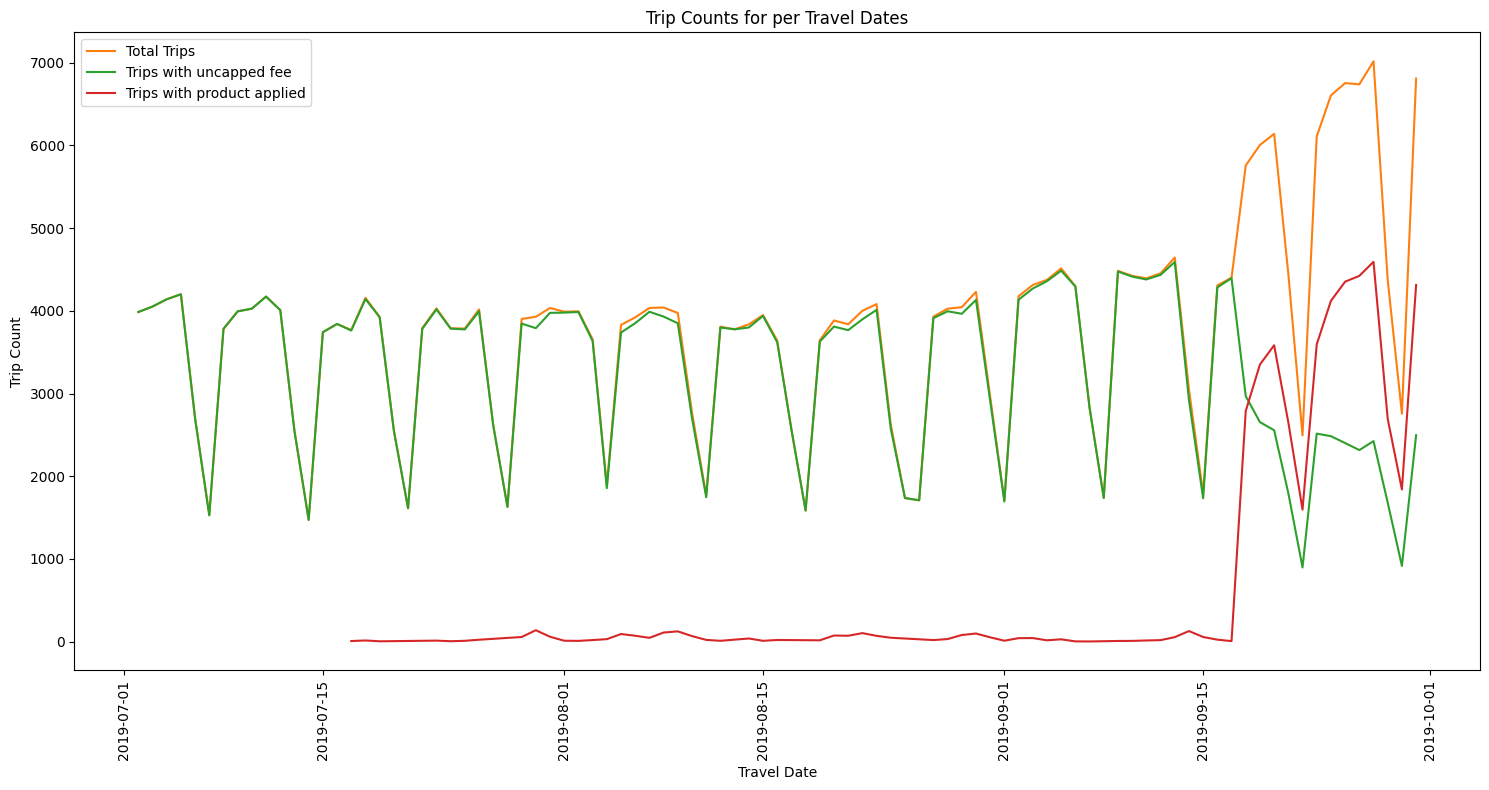

In [9]:
pdf = graph_df.toPandas()

plt.figure(figsize=(15, 8))
for product_id in pdf['product_id'].unique():
    subset = pdf[pdf['product_id'] == product_id]
    plt.plot(subset['date'], subset['trip_count'], label=product_id)

plt.xlabel('Travel Date')
plt.ylabel('Trip Count')
plt.title('Trip Counts for per Travel Dates')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

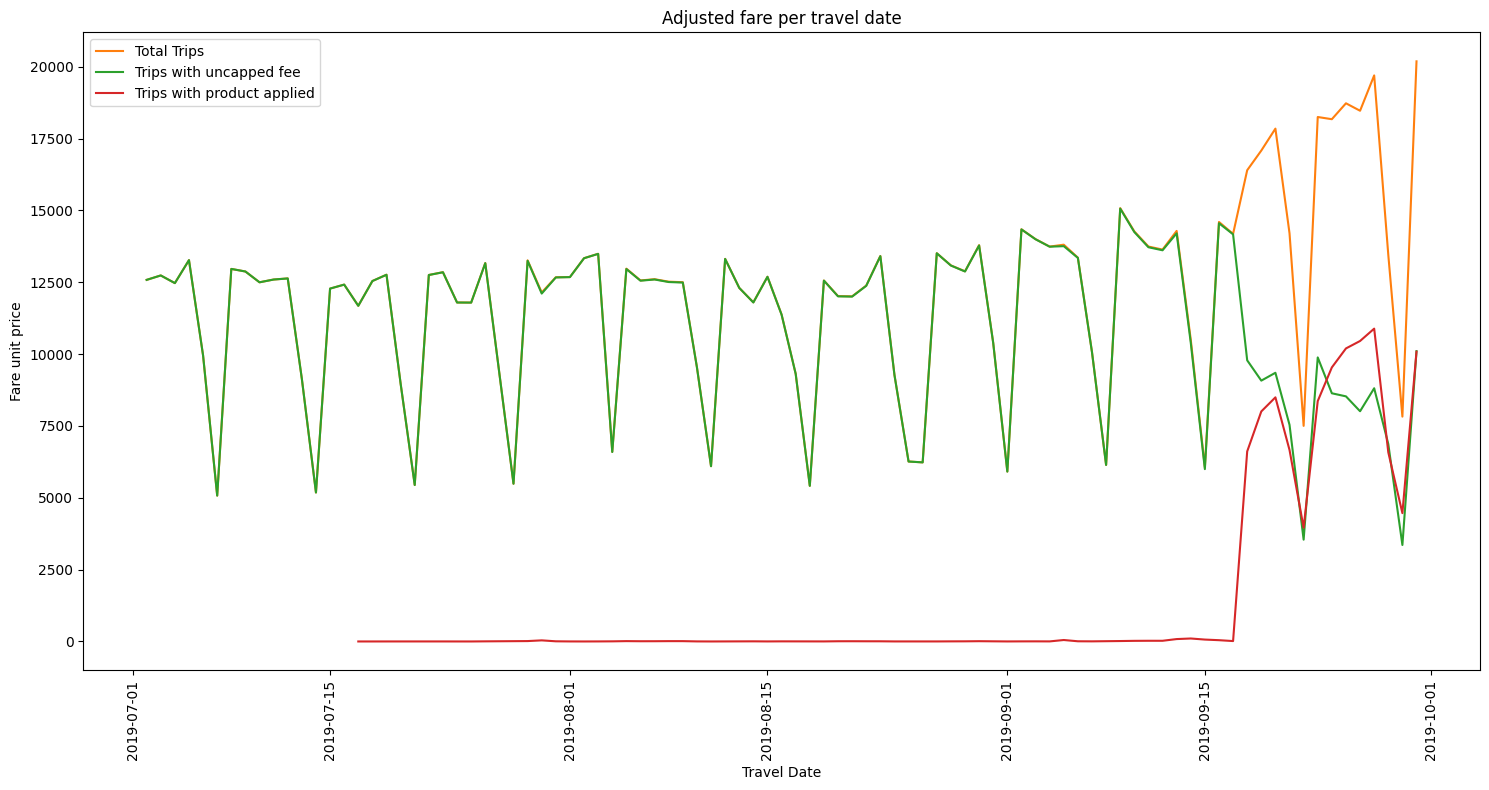

In [10]:
pdf = graph_df.toPandas()

plt.figure(figsize=(15, 8))
for product_id in pdf['product_id'].unique():
    subset = pdf[pdf['product_id'] == product_id]
    #plt.plot(subset['date'], subset['original_amt_agg'], label=product_id)
    plt.plot(subset['date'], subset['adjusted_amt_agg'], label=product_id)


plt.xlabel('Travel Date')
plt.ylabel('Fare unit price')
plt.title('Adjusted fare per travel date')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Week on week growth (WoW)

Since data only goes up to day 1 of week 40 of 2019 (1st October) we will only consider up to week 39. Halfway through week 38 is when product capping became effective.

1. From week 38 onwards there was at least a a 20% WoW increase in trips and 12% increase in fares (adjusted)

In [11]:
sql_query = f"""
WITH weekly_aggregate as (
    SELECT week, 
    year, 
    product_id, 
    SUM(trip_count) as trip_count,
    SUM(original_amt_agg) as original_amt_agg,
    SUM(adjusted_amt_agg) as adjusted_amt_agg
    FROM (
        
        SELECT 
            d.*, 
            t.product_id, 
            t.trip_count, 
            t.original_amt_agg, 
            t.adjusted_amt_agg
        FROM dim_date d
        LEFT JOIN agg_total_trips t ON t.travel_dt = d.date
        WHERE d.date > '{REPORTING_START_DATE}' AND d.date < '{REPORTING_END_DATE}'
    )
    GROUP BY 1,2,3
    HAVING COUNT(*) = 7
    ORDER BY 1 desc ,2
)
SELECT 
    week, 
    year, 
    product_id, 
    trip_count, 
    original_amt_agg, 
    adjusted_amt_agg,
    LAG(trip_count, 1) OVER (PARTITION BY product_id ORDER BY year, week) AS previous_week_trip_count,
    ((trip_count - LAG(trip_count, 1) OVER (PARTITION BY product_id ORDER BY year, week)) / 
    LAG(trip_count, 1) OVER (PARTITION BY product_id ORDER BY year, week)) * 100 AS week_on_week_trip_growth_pct,
    LAG(adjusted_amt_agg, 1) OVER (PARTITION BY product_id ORDER BY year, week) AS previous_week_adj_amt,
    ((adjusted_amt_agg - LAG(adjusted_amt_agg, 1) OVER (PARTITION BY product_id ORDER BY year, week)) / 
    LAG(adjusted_amt_agg, 1) OVER (PARTITION BY product_id ORDER BY year, week)) * 100 AS week_on_week_adj_growth_pct
FROM 
    weekly_aggregate
ORDER BY 1 DESC, 2 DESC
 """

wow_df = spark.sql(sql_query)
wow_df.show()


+----+----+-----------+----------+------------------+------------------+------------------------+----------------------------+---------------------+---------------------------+
|week|year| product_id|trip_count|  original_amt_agg|  adjusted_amt_agg|previous_week_trip_count|week_on_week_trip_growth_pct|previous_week_adj_amt|week_on_week_adj_growth_pct|
+----+----+-----------+----------+------------------+------------------+------------------------+----------------------------+---------------------+---------------------------+
|  39|2019|Total Trips|     40349|116510.69999999997|114618.39999999998|                   33546|           20.27961604960353|   101833.79999999999|         12.554377819545174|
|  38|2019|Total Trips|     33546|          102744.9|101833.79999999999|                   27235|          23.172388470717824|              87602.3|         16.245578027060915|
|  37|2019|Total Trips|     27235| 87931.90000000001|           87602.3|                   26239|          3.795876